# **Stanford Transportation - ChargePoint EV Chargers - Sep-2023**

## **Initialization**

### **Code Setup**

In [1]:
from datetime import datetime, timedelta
import sys
from typing import Optional
from zoneinfo import ZoneInfo

from IPython.display import display
from matplotlib import pyplot as plt
import networkx as nx
import pandas as pd

# Add repo's python directory to PYTHONPATH so we can import our utilities
sys.path.append('../python/')

from s3l_utils.dataset import Dataset
from s3l_utils.notebook import print_md
from s3l_utils.functional import grouper

# Output formatting
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Timezone abbreviation to zoneinfo
tz_abbrev_to_zoneinfo = {
    'PDT': ZoneInfo('US/Pacific'),
    'PST': ZoneInfo('US/Pacific'),
}

# Convert alarm times to proper datetimes... why is this so hard???
def alarm_time_to_datetime(alarm_time):
    if isinstance(alarm_time, datetime):
        return alarm_time

    components = alarm_time.split()
    naive_time = datetime.strptime(' '.join(components[:-1]), '%Y-%m-%d %H:%M:%S')
    aware_time = naive_time.astimezone(tz_abbrev_to_zoneinfo[components[-1][1:-1]])
    return aware_time

# Summarize table
def summarize_dataframe_md(df: pd.DataFrame, header: str = ''):
    if header:
        print_md(f'#### **{header}**')
    
    print_md(f'**Number of Rows:** {len(df)}')
    print_md(f'**Columns:** {", ".join(df.columns)}')

    print_md('#### **Unique Column Values**')
    for column in df.columns:
        unique_column_values = ', '.join(filter(None, map(str, list(df[column].unique()))))
        print_md(f'##### **{column.strip()}**')
        print_md(unique_column_values)

# Pandas options
# pd.set_option('display.max_rows', None)

### **Load and Prepare Dataset**

In [2]:
# Load dataset and tables
dataset = Dataset('../data/manifest.yml')
station_overview = dataset.stations.overview
alarms = dataset.reports.alarms
station_inventory = dataset.organizations.inventory.stations

# Canonicalize alarm times to US/Pacific datetimes
if not pd.api.types.is_datetime64_any_dtype(alarms['Alarm Time']):
    # alarms['Alarm Time'] = pd.to_datetime(alarms['Alarm Time'].map(lambda x: ' '.join(x.split()[:-1]))).dt.tz_localize('US/Pacific', ambiguous='NaT')
    dst_map = alarms['Alarm Time'].str.contains('PST')
    alarms['Alarm Time'] = pd.to_datetime(alarms['Alarm Time'].map(lambda x: ' '.join(x.split()[:-1]))).dt.tz_localize('US/Pacific', dst_map)

## **Analysis**

### **Station Overview**

In [3]:
summarize_dataframe_md(station_overview, 'Station Overview Summary')

#### **Station Overview Summary**

**Number of Rows:** 109

**Columns:** Model Number, Station Name, Org Name, MAC Address, System S/N, Address 1, Address 2, Floor Label, City, State, Zip/Postal Code, County, Country , Activation Status, Network Status, Station Status, Port 1 Status, Port 2 Status, No. of Ports, Pricing Policy Name, Reservations, Station Message, Enabled, Station Activation Type, Usable By, Visibility (Access Policy Name), EVSE ID, Radio Group Name, Software Version, Customer Category, Customer Subcategory, Circuit Sharing, Currency Name, Power Select / AC Breaker Rating, Scheduled Charging Policy Name, Warranty, Station Activation Date, Warranty Expiration Date, Warranty Service, Plug Type, Device Access Restriction, Waitlist Policy Name, Asset Tag ID, Meter ID, Service Delivery Point ID, Point of Service ID, Account ID, Circuit ID, Panel ID, Customer Name, Customer ID, Site ID, Site mode, Site Validation Status, Paired, Latitude, Longitude

#### **Unique Column Values**

##### **Model Number**

CT4020-HD, CT4020-HD-GW, CT4020-HD2-GW-LTE, CT4010-HD-GW, CT4010-HD, CPE200T-S-CHD-CMB

##### **Station Name**

STANFORD / THO NGW-B5, STANFORD / THO NGW-B4, STANFORD / THO NGW-B3, STANFORD / THO NGW-B2, STANFORD / THO NGW-B1, STANFORD / THO NGW-A5 ADA, STANFORD / THO NGW-A4, STANFORD / THO NGW-A3, STANFORD / THO NGW-A2, STANFORD / THO NGW-A1, STANFORD / THO GW-B, STANFORD / THO GW-A, STANFORD / TH WALL MOUNT, STANFORD / TH STATION 1, STANFORD / STATION 9, STANFORD / STATION 8 PS-5, STANFORD / STATION 8, STANFORD / STATION 7 PS-5, STANFORD / STATION 7, STANFORD / STATION 6 PS-5, STANFORD / STATION 6, STANFORD / STATION 5 PS-5, STANFORD / STATION 5, STANFORD / STATION 4 PS-5, STANFORD / STATION 4, STANFORD / STATION 3 PS-5, STANFORD / STATION 3, STANFORD / STATION 2 TMU, STANFORD / STATION 2 PS-5, STANFORD / STATION 2, STANFORD / STATION 11, STANFORD / STATION 10, STANFORD / STATION 1 TMU, STANFORD / STATION 1 PS-5, STANFORD / STATION 1, STANFORD / ROBLE LL2-12, STANFORD / OAK ROAD #1, STANFORD / CD STATION 6, STANFORD / CD STATION 4, STANFORD / CD STATION 3, STANFORD / CD STATION 2, STANFORD / CD STATION 1, STANFORD / CD GATEWAY #3, STANFORD / CD GATEWAY #2, STANFORD / CD GATEWAY #1, STANFORD / CAM 6 LL1, STANFORD / CAM 5 LL1, STANFORD / CAM 4 LL1, STANFORD / CAM 3 LL1, STANFORD / CAM 2 LL1, STANFORD / CAM 1 LL1, SRWC / RWC L5 5, SRWC / RWC L5 4, SRWC / RWC L5 3, SRWC / RWC L5 2, SRWC / RWC L5 1, SRWC / RWC L4 4, SRWC / RWC L4 3, SRWC / RWC L4 2, SRWC / RWC L4 1, SRWC / RWC L3 4, SRWC / RWC L3 3, SRWC / RWC L3 2, SRWC / RWC L3 1, SRWC / RWC L2 4, SRWC / RWC L2 3, SRWC / RWC L2 2, SRWC / RWC L2 1, SRWC / RWC L1 6, SRWC / RWC L1 5, SRWC / RWC L1 4, SRWC / RWC L1 3, SRWC / RWC L1 2, SRWC / RWC L1 1, SRWC / RWC B1 4, SRWC / RWC B1 3, SRWC / RWC B1 2, SRWC / RWC B1 1, SRWC / CHARGER 5, SRWC / CHARGER 4, SRWC / CHARGER 3, SRWC / CHARGER 2, SRWC / CHARGER 1, ROBLE / ROBLE LL2-9, ROBLE / ROBLE LL2-8, ROBLE / ROBLE LL2-7, ROBLE / ROBLE LL2-6, ROBLE / ROBLE LL2-5, ROBLE / ROBLE LL2-4, ROBLE / ROBLE LL2-3, ROBLE / ROBLE LL2-2, ROBLE / ROBLE LL2-14, ROBLE / ROBLE LL2-13, ROBLE / ROBLE LL2-11, ROBLE / ROBLE LL2-10, ROBLE / ROBLE LL2-1, ROBLE / ROBLE LL1-DIS, ROBLE / ROBLE LL1-9, ROBLE / ROBLE LL1-8, ROBLE / ROBLE LL1-7, ROBLE / ROBLE LL1-6, ROBLE / ROBLE LL1-5, ROBLE / ROBLE LL1-4, ROBLE / ROBLE LL1-3, ROBLE / ROBLE LL1-2, ROBLE / ROBLE LL1-12, ROBLE / ROBLE LL1-11, ROBLE / ROBLE LL1-10, ROBLE / ROBLE LL1-1

##### **Org Name**

Stanford University

##### **MAC Address**

0024:B100:0003:12F8, 0024:B100:0003:130F, 0024:B100:0003:12EE, 0024:B100:0003:12F1, 0024:B100:0003:12D9, 0024:B100:0003:1318, 0024:B100:0003:1312, 0024:B100:0003:130E, 0024:B100:0003:130B, 0024:B100:0003:12EB, 0024:B100:0003:2C1C, 0024:B100:0003:2A8C, 0024:B100:0002:16F3, 0024:B100:0004:0667, 0024:B100:0006:C0E1, 0024:B100:0002:15D4, 0024:B100:0006:BD1D, 0024:B100:0002:1C6A, 0024:B100:0006:C802, 0024:B100:0002:15D0, 0024:B100:0006:BD13, 0024:B100:0002:15DF, 0024:B100:0006:BD20, 0024:B100:0002:13E5, 0024:B100:0006:C80F, 0024:B100:0002:1F6C, 0024:B100:0006:C80C, 0024:B100:0006:BC3D, 0024:B100:0004:3B91, 0024:B100:0006:C0E2, 0024:B100:000C:083C, 0024:B100:0006:C7DC, 0024:B100:0003:33C3, 0024:B100:0002:1EED, 0024:B100:0006:4538, 0024:B100:0002:2A6E, 0024:B100:0003:824E, 0024:B100:0003:2ADF, 0024:B100:0004:2ED8, 0024:B100:0003:2AB1, 0024:B100:0004:A22C, 0024:B100:0003:2AB5, 0024:B100:0004:1B12, 0024:B100:0004:A250, 0024:B100:0004:C4B2, 0024:B100:0003:C68A, 0024:B100:0003:C689, 0024:B100:0003:BF91, 0024:B100:0003:BF3D, 0024:B100:0004:0E93, 0024:B100:0003:BF3B, 0024:B100:0002:8DD9, 0024:B100:0002:8E32, 0024:B100:0002:A917, 0024:B100:0003:1F95, 0024:B100:0002:9194, 0024:B100:0002:8E49, 0024:B100:0002:8FD1, 0024:B100:0002:8E36, 0024:B100:0002:8E37, 0024:B100:0002:8E28, 0024:B100:0002:8E02, 0024:B100:0002:91C3, 0024:B100:0002:918F, 0024:B100:0002:8E2F, 0024:B100:0002:8E27, 0024:B100:0002:8FCA, 0024:B100:0002:8E2C, 0024:B100:0002:B04A, 0024:B100:0002:919B, 0024:B100:0002:AE14, 0024:B100:0002:AD71, 0024:B100:0002:9202, 0024:B100:0002:594F, 0024:B100:0002:8DDC, 0024:B100:0003:9836, 0024:B100:0002:9193, 0024:B100:0002:8E4A, 000D:6F00:04F8:B0AC, 0024:B100:0002:5752, 0024:B100:0002:575E, 0024:B100:0002:5144, 0024:B100:0002:4AEB, 0024:B100:0002:295F, 0024:B100:0002:2A8E, 0024:B100:0002:2A74, 0024:B100:0002:2A6B, 0024:B100:0002:2A70, 0024:B100:0002:2A80, 0024:B100:0002:2955, 0024:B100:0002:297C, 0024:B100:0002:5154, 0024:B100:0002:294E, 0024:B100:0002:2A7B, 0024:B100:0002:2A71, 0024:B100:0002:5134, 0024:B100:0002:299E, 0024:B100:0004:5D08, 0024:B100:0002:2A7C, 0024:B100:0002:2940, 0024:B100:0002:2954, 0024:B100:0003:D5D6, 0024:B100:0003:D26F, 0024:B100:0002:2A73, 0024:B100:0004:20C4, 0024:B100:0004:0EC1, 0024:B100:0002:3F5A, 0024:B100:0004:5CE8, 0024:B100:0002:5158

##### **System S/N**

184141024581, 184141024600, 184141024577, 184141024593, 184141024567, 184141024610, 184141024603, 184141024588, 184141024608, 184141024573, 184841030920, 184741030870, 143641006567, 201741012775, 220241003311, 143441006254, 220141000705, 145041008118, 220241003288, 143441006255, 220141000697, 143441006275, 220141000714, 143041005775, 220241003284, 150341000232, 220241003312, 220141000444, 200541004831, 220241003310, 231641072278, 220241003273, 153741004116, 150241000120, 213841045402, 152741003067, 193041017182, 184741030714, 192741015842, 184741030692, 210241001954, 184741030683, 192641015360, 210241001974, 211141011323, 195241034416, 195241034419, 195041032475, 195041032407, 170141000309, 195041032410, 173441009978, 173441009986, 175241017410, 184541028755, 173641010743, 173441009989, 173541010301, 173441009990, 173441010008, 173441009974, 173541010298, 173641010752, 173641010749, 173441009983, 173441009973, 173541010306, 173441009984, 180241000629, 173641010742, 175241017163, 175141017015, 173641010746, 164041005488, 173441009933, 164741006937, 173641010737, 173441009991, 37569, 163841004932, 163841004941, 162741003523, 153441003891, 152541002783, 152741003076, 152741003072, 152741003068, 152741003081, 152741003082, 152541002779, 152541002807, 162841003554, 152541002762, 152741003077, 152741003079, 162741003546, 152641002898, 183441017415, 152741003088, 152541002775, 152541002778, 200441003033, 200341002120, 152741003075, 185141033955, 172641007698, 155141008435, 164941007425, 162841003560

##### **Address 1**

740 Serra St, 295 Galvez St, 400 El Camino Real, 340 Oak Rd, 495 El Camino Real, 360 Oak Rd, 526-566 Lagunita Dr, 526-566 Stanford UniversityLagunita Dr, 375 Santa Teresa St, 484 Oak Rd, 742 Campus Drive, 453 Quarry Rd, 425 Broadway, 2850 Bay Rd, 2858 Bay Rd, 585 Broadway, 900-998 Douglas Ave, 373 Santa Teresa St, 287 Santa Teresa St, 671-725 Panama St

##### **Address 2**

Manzanita Garage

##### **Floor Label**

1, L5, L4, L3, L2, L1, B1

##### **City**

Stanford, Menlo Park, Palo Alto, Redwood City

##### **State**

California

##### **Zip/Postal Code**

94305, 94025, 94304, 94063

##### **County**

Santa Clara County, San Mateo County

##### **Country**

United States

##### **Activation Status**

Activated

##### **Network Status**

Unreachable, Reachable

##### **Station Status**

Watch List, Available, Needs Service, Inuse

##### **Port 1 Status**

Watch List, Available, In Use, Needs Service

##### **Port 2 Status**

Watch List, Available, In Use, Needs Service

##### **No. of Ports**

2, 1

##### **Pricing Policy Name**

$1 per hr enforcement hours, $2 per hr enforcement hours $1 per hr otherwise (e, Stanford University Mirrored

##### **Reservations**

Disabled

##### **Station Message**

Plugged In Required

##### **Enabled**

Yes

##### **Station Activation Type**

Public

##### **Usable By**

All Drivers, Stanford University Mirrored

##### **Visibility (Access Policy Name)**

No Drivers, All Drivers, Stanford University Mirrored

##### **EVSE ID**

1942901, 1942891, 1942871, 1942831, 1942771, 1943001, 1942971, 1942961, 1942951, 1942911, 715031, 715051, 119361, 118801, 13124741, 110213, 13124781, 117141, 13124701, 110125, 13124811, 110209, 13124771, 107663, 13124731, 118797, 13124761, 118781, 119315, 13124721, 13125171, 13125341, 119355, 118785, 13124711, 126643, 2002541, 5499441, 5499291, 5499251, 5499161, 5498991, 5390121, 5441611, 5456051, 5485451, 5474401, 5474381, 5475761, 5480591, 5474391, 239571, 239611, 428361, 738381, 254601, 239441, 247101, 239411, 239671, 239621, 246721, 254841, 254621, 239541, 239631, 246861, 239531, 446341, 254801, 422291, 419271, 254681, 254641, 239661, 246781, 254711, 239511, 158679, 168373, 168401, 162597, 2100951, 125893, 126669, 126653, 126645, 126683, 126679, 125887, 125961, 162667, 125833, 126661, 126673, 162657, 126187, 126651, 126695, 125855, 125881, 126277, 125885, 126663, 126169, 162655, 148717, 126693, 162797

##### **Radio Group Name**

RG-GW1, RG-GW2, Track House, RG_00040667, GW 9, PS5 - SW Wall, GW 8, GW 7, GW 6, GW 5, GW 4, PS-5 NW Wall, GW 3, RG_0006BC3D, GW 2, GW 11, GW 10, TMU, GW 1, LL2 Group 1, Oak Road RG 01, Campus Dr RG2, RG_00042ED8, Campus Dr RG1, RG_0004A22C, Campus Dr RG3, Quarry Rd RG 6, Quarry Rd RG 5, Quarry Rd RG 4, Quarry Rd RG 3, Quarry Rd RG 2, Quarry Rd RG 1, RWC L5, RWC L4, RWC L3, RWC L2, RWC L1, RWC B1, Broadway GW2, Broadway GW1, Roble LL2 Group 2, Roble LL1 Group 2, RG_00045D08, Roble LL1 Group 1, RG_0003D5D6, RG_0003D26F, RG_000420C4, RG_00045CE8

##### **Software Version**

4.6.0.46, 4.20.0+2023.02.10.63-alpha, 4.6.0.39, 4.5.0.40, 3.7.9.19-6777192/v1.5.80000000000, 4.6.0.33, 4.6.0.35

##### **Customer Category**

Education, Workplace

##### **Customer Subcategory**

University / College, General

##### **Circuit Sharing**

Disabled, Enabled

##### **Currency Name**

U.S. Dollars (USD)

##### **Power Select / AC Breaker Rating**

40A, 30A

##### **Scheduled Charging Policy Name**

##### **Warranty**

ChargePoint Assure, Standard Warranty

##### **Station Activation Date**

2020-09-17 15:38:10, 2020-09-17 15:35:51, 2020-09-17 15:29:31, 2020-09-17 15:36:26, 2020-09-17 15:38:46, 2020-09-17 15:40:18, 2020-09-17 15:39:25, 2020-09-17 15:42:11, 2020-09-17 15:44:39, 2020-09-17 15:40:00, 2020-08-19 23:02:32, 2020-08-19 23:10:20, 2015-03-19 08:32:56, 2015-03-20 12:37:34, 2023-01-19 08:43:35, 2016-06-08 14:14:10, 2023-01-19 08:41:24, 2016-06-08 14:56:20, 2023-02-02 10:49:00, 2016-06-08 14:54:04, 2023-01-19 08:37:34, 2016-06-08 14:45:44, 2023-01-19 08:33:44, 2016-06-08 14:11:06, 2023-01-19 08:31:07, 2015-03-18 15:43:43, 2023-01-19 08:26:50, 2015-03-30 07:36:25, 2015-03-18 15:12:52, 2023-01-19 08:20:56, 2023-05-11 14:04:13, 2023-03-06 12:38:27, 2015-03-19 15:24:31, 2015-03-18 15:22:59, 2023-01-19 08:10:23, 2017-02-01 11:44:03, 2020-05-28 05:26:59, 2020-12-22 17:53:21, 2020-11-25 17:06:57, 2020-11-25 17:07:07, 2020-11-25 16:50:44, 2020-11-25 16:52:25, 2021-05-11 09:01:41, 2020-12-19 23:28:41, 2020-11-25 14:57:07, 2021-03-22 10:30:10, 2021-03-16 14:00:45, 2021-03-16 13:53:28, 2021-03-22 11:53:21, 2021-10-12 12:55:13, 2021-03-16 12:59:29, 2019-03-15 06:51:13, 2019-03-15 06:55:18, 2019-03-15 05:56:15, 2019-03-15 06:53:15, 2019-03-15 06:49:16, 2019-03-15 06:35:19, 2019-03-15 05:44:19, 2019-03-15 06:39:16, 2019-03-15 06:37:20, 2019-03-15 06:45:14, 2019-03-15 05:38:11, 2019-03-15 06:47:15, 2019-03-15 06:43:15, 2019-03-15 06:39:14, 2019-03-15 06:35:18, 2019-03-15 05:36:14, 2019-03-15 06:37:13, 2019-03-15 05:34:14, 2019-03-15 06:43:16, 2019-03-15 06:49:14, 2019-03-15 06:39:15, 2019-03-15 06:47:14, 2019-03-15 06:45:15, 2019-03-15 05:54:18, 2019-03-15 05:22:14, 2019-03-15 05:52:14, 2019-03-15 05:56:13, 2020-11-11 06:56:36, 2017-03-23 17:38:00, 2017-03-23 17:37:23, 2017-03-23 16:35:37, 2020-02-11 13:52:31, 2017-01-31 15:24:07, 2017-01-31 14:43:12, 2017-01-31 15:24:08, 2017-01-31 15:20:58, 2017-02-01 03:56:40, 2017-01-31 15:27:12, 2017-01-27 17:27:15, 2017-01-27 18:33:32, 2017-01-27 13:18:14, 2017-01-27 13:30:53, 2017-01-31 16:36:41, 2017-02-01 02:20:56, 2017-01-27 16:59:07, 2017-01-27 15:02:08, 2017-01-26 17:26:13, 2017-01-26 17:35:38, 2017-01-26 17:45:11, 2017-01-26 17:32:28, 2017-01-26 18:10:23, 2017-01-26 17:48:17, 2017-01-26 17:29:23, 2017-01-26 17:51:26, 2017-01-26 14:33:33, 2017-01-26 15:27:05, 2017-01-31 15:17:50, 2017-01-26 16:39:08

##### **Warranty Expiration Date**

2023-12-31, 2027-09-11, 2021-05-28, 2026-03-22, 2026-03-16, 2026-10-12, 2020-03-15, 2021-11-11, 2018-03-23, 2021-02-11

##### **Warranty Service**

Parts & Labor, Parts Only

##### **Plug Type**

J1772, CHAdeMO, Combo

##### **Device Access Restriction**

NONE

##### **Waitlist Policy Name**

##### **Asset Tag ID**

152541002783, 152741003076, 152741003072, 152741003068, 152741003081, 152741003082, 152541002779, 152541002807, 162841003554, 152541002762, 152741003077, 152741003079, 162741003546, 152641002898, 152741003088, 152541002775, 152541002778, 152641002895, 152541002782, 152741003075, 155141008435, 162841003560

##### **Meter ID**

SN152741003067

##### **Service Delivery Point ID**

##### **Point of Service ID**

##### **Account ID**

##### **Circuit ID**

##### **Panel ID**

##### **Customer Name**

Stanford Parking & Transportation Services, ABM Electrical & Lighting Solutions, LLC (SoCal), Oak Park Unified School District, The Board of Trustees of The Leland Stanford Junior University, Stanford University

##### **Customer ID**

0014000000wFNW2, 0014000000aMh42, 0014000000gHPcz, 0014000000kfOC5

##### **Site ID**

##### **Site mode**

##### **Site Validation Status**

Validated, Not Validated

##### **Paired**

No

##### **Latitude**

37.426793659810016, 37.42680510868808, 37.42783416929919, 37.426802179905486, 37.4268107, 37.426785139713566, 37.4278075443645, 37.4278757041782, 37.43220734102387, 37.432241418935455, 37.45041, 37.43171044847697, 37.450394, 37.43175282649997, 37.45039733830973, 37.431757357410085, 37.45037, 37.43174023441741, 37.43175217797956, 37.4503876418016, 37.43187166339748, 37.450404144282025, 37.4235392953854, 37.43193981951077, 37.450413, 37.450653, 37.450396159211294, 37.42353031813845, 37.43199093655503, 37.42621544618659, 37.42925895023151, 37.42546342823224, 37.42563276795673, 37.42566152372096, 37.42562249843807, 37.42558910177513, 37.42552093987972, 37.425431477297856, 37.425595491949615, 37.43758993277954, 37.43994537522589, 37.437244799999995, 37.44008806162375, 37.440014588811074, 37.43996028277272, 37.483830085831535, 37.48380241662368, 37.48377900420903, 37.483708766921104, 37.483685354477096, 37.48385881922885, 37.4837598485916, 37.48374069296927, 37.483682161870526, 37.48382928768144, 37.4836513, 37.4837279225516, 37.483678969263806, 37.48382582903098, 37.483760912792704, 37.48375239918352, 37.48371408793006, 37.48384553997287, 37.48387691062148, 37.483716216333534, 37.483693069942404, 37.483680565567184, 37.48365555681048, 37.48380454502468, 37.483723665745266, 37.48365412633115, 37.48465735481143, 37.4846431782048, 37.4849383, 37.48494042836861, 37.484929786524965, 37.426269408993285, 37.426286449302594, 37.42632052990961, 37.426363130646514, 37.42638869107704, 37.42643129177518, 37.426439811911905, 37.426329050058925, 37.42631200975929, 37.42620976788015, 37.42622680820304, 37.426448332047634, 37.42632368474175, 37.42649998495956, 37.426465904434274, 37.426435544044864, 37.4264255395908, 37.42678556649676, 37.42639846349808, 37.426411897405714, 37.42634876198768, 37.426527734861885, 37.42647208247871, 37.426317033400885, 37.426334040085905

##### **Longitude**

-122.1592395153442, -122.15920263497024, -122.15657205847889, -122.15917514232784, -122.1591858711639, -122.1591322269836, -122.15916441349178, -122.15919659999996, -122.15915368465572, -122.15660022167354, -122.15649293331296, -122.16329689629517, -122.1632325232788, -122.177246, -122.1828376358759, -122.17716, -122.18284779288138, -122.17725536441804, -122.18285127986668, -122.17628, -122.18283775917509, -122.17633, -122.18286498364182, -122.17729425644876, -122.1826917650818, -122.17726810491084, -122.17110856613158, -122.18259520555728, -122.17723, -122.17668, -122.17727013988112, -122.17105130926204, -122.18247718836062, -122.17725, -122.17528922540896, -122.1844759464882, -122.15975492268448, -122.159489383992, -122.15954705148584, -122.15954674077344, -122.15958057909852, -122.15980588465575, -122.15982197790986, -122.15962885886078, -122.1714015910874, -122.17132815833588, -122.1716781, -122.1711511325409, -122.17118331904908, -122.17122623439332, -122.20392049695892, -122.20392586137694, -122.20395000125808, -122.20398486997529, -122.20401705648344, -122.20390306260032, -122.20396877672118, -122.20397682334824, -122.2040090098564, -122.20393357272786, -122.2037542, -122.2039915754978, -122.2040251031105, -122.2039164736454, -122.20396475340766, -122.20398755218427, -122.20399425770682, -122.20391669583968, -122.2038842871372, -122.2040063276474, -122.2040200739686, -122.20403113808078, -122.20404253746908, -122.20393122579496, -122.20393927242202, -122.20398218776626, -122.20403712440223, -122.20684677486878, -122.20742303177298, -122.2067073, -122.20677167301636, -122.20657855396728, -122.17548427354126, -122.17554864655762, -122.17566666375428, -122.17574176560667, -122.1758168674591, -122.17590269814758, -122.1759778, -122.17605290185242, -122.17551646004944, -122.17561301957396, -122.17535552750854, -122.17538771401672, -122.17614946137697, -122.17543473729552, -122.1761681952454, -122.17600726270445, -122.17591751852416, -122.17584955714722, -122.17600974127812, -122.17572525714723, -122.17569146903384, -122.17561776455688, -122.17609522209004, -122.17608156085204, -122.17560433068849, -122.17557698584444

### **Station and Port Status**

In [4]:
num_stations = len(station_overview)
num_ports = station_overview['No. of Ports'].sum()

print_md(f'**Number of Stations:** {num_stations}')
print_md(f'**Number of Ports:** {num_ports}')

print_md('#### **Station Count by Status**')
station_status_counts = station_overview.value_counts('Station Status')
assert num_stations == station_status_counts.sum()
display(station_status_counts.to_frame())

num_stations_need_service_or_watch_list = station_status_counts.loc[['Watch List', 'Needs Service']].sum()
percent_stations_need_service_or_watch_list = round(num_stations_need_service_or_watch_list / num_stations * 100, 2)
print_md(f'**Stations Needing Service or on Watch List:** {num_stations_need_service_or_watch_list} ({percent_stations_need_service_or_watch_list}%)')

print_md('#### **Port Count by Status**')
port_status_counts = station_overview[['Port 1 Status', 'Port 2 Status']].melt()['value'].value_counts().drop('')
assert num_ports == port_status_counts.sum()
display(port_status_counts.to_frame())

num_ports_need_service_or_watch_list = port_status_counts.loc[['Watch List', 'Needs Service']].sum()
percent_ports_need_service_or_watch_list = round(num_ports_need_service_or_watch_list / num_ports * 100, 2)
print_md(f'**Ports Needing Service or on Watch List:** {num_ports_need_service_or_watch_list} ({percent_ports_need_service_or_watch_list}%)')

**Number of Stations:** 109

**Number of Ports:** 205

#### **Station Count by Status**

,count
Station Status,
Available,88
Watch List,11
Needs Service,7
Inuse,3


**Stations Needing Service or on Watch List:** 18 (16.51%)

#### **Port Count by Status**

,count
value,
Available,144
In Use,31
Watch List,22
Needs Service,8


**Ports Needing Service or on Watch List:** 30 (14.63%)

### **Alarms**

In [5]:
summarize_dataframe_md(alarms.drop('Alarm Time', axis=1), 'Alarms Summary')

#### **Alarms Summary**

**Number of Rows:** 340967

**Columns:** Display Name, MAC Address, Org Name, Alarm Severity, Alarm Name, Alarm ID, FRU Name, Model Number, Port, Reason For Clearing, Component Serial Number

#### **Unique Column Values**

##### **Display Name**

STANFORD / STATION 1 TMU, STANFORD / STATION 2 TMU, STANFORD / CD STATION 6, STANFORD / CD GATEWAY #2, STANFORD / THO NGW-B5, STANFORD / THO NGW-B1, STANFORD / THO NGW-B4, STANFORD / THO NGW-B3, STANFORD / THO NGW-B2, STANFORD / THO GW-B, ROBLE / ROBLE LL1-11, ROBLE / ROBLE LL1-8, ROBLE / ROBLE LL1-12, ROBLE / ROBLE LL1-6, ROBLE / ROBLE LL1-3, ROBLE / ROBLE LL1-1, ROBLE / ROBLE LL1-DIS, ROBLE / ROBLE LL1-2, STANFORD / TH STATION 1, ROBLE / ROBLE LL2-9, ROBLE / ROBLE LL2-1, SRWC / RWC L4 3, SRWC / RWC L2 2, ROBLE / ROBLE LL2-14, STANFORD / CAM 5 LL1, SRWC / RWC L2 3, SRWC / RWC L2 4, SRWC / RWC L2 1, ROBLE / ROBLE LL2-10, ROBLE / ROBLE LL2-13, ROBLE / ROBLE LL2-2, ROBLE / ROBLE LL1-7, ROBLE / ROBLE LL2-4, ROBLE / ROBLE LL2-8, STANFORD / STATION 3 PS-5, STANFORD / ROBLE LL2-12, STANFORD / TH WALL MOUNT, ROBLE / ROBLE LL2-3, ROBLE / ROBLE LL2-5, ROBLE / ROBLE LL2-11, STANFORD / STATION 2 PS-5, ROBLE / ROBLE LL1-5, ROBLE / ROBLE LL1-10, ROBLE / ROBLE LL2-6, ROBLE / ROBLE LL2-7, STANFORD / STATION 1 PS-5, ROBLE / ROBLE LL1-9, ROBLE / ROBLE LL1-4, SRWC / RWC L1 6, SRWC / RWC L1 5, SRWC / RWC L1 3, SRWC / RWC L1 4, STANFORD / THO NGW-A3, STANFORD / THO GW-A, STANFORD / THO NGW-A5 ADA, STANFORD / THO NGW-A1, STANFORD / THO NGW-A4, STANFORD / THO NGW-A2, STANFORD / CAM 1 LL1, STANFORD / STATION 11, STANFORD / CAM 2 LL1, STANFORD / STATION 2, STANFORD / STATION 3, STANFORD / STATION 5, STANFORD / STATION 7 PS-5, STANFORD / STATION 7, SRWC / RWC L5 2, SRWC / RWC L3 4, SRWC / RWC L3 2, SRWC / RWC L3 1, SRWC / RWC L4 2, SRWC / RWC L4 1, SRWC / RWC L1 1, SRWC / RWC L1 2, SRWC / RWC L5 5, SRWC / RWC L5 1, SRWC / RWC L5 4, SRWC / RWC B1 2, SRWC / RWC B1 1, SRWC / RWC B1 4, STANFORD / STATION 6 PS-5, STANFORD / STATION 8 PS-5, STANFORD / STATION 5 PS-5, STANFORD / CD GATEWAY #3, STANFORD / CD STATION 2, STANFORD / CD STATION 3, STANFORD / CD GATEWAY #1, STANFORD / CD STATION 1, STANFORD / CAM 3 LL1, STANFORD / STATION 4 PS-5, SRWC / RWC L5 3, SRWC / RWC L4 4, SRWC / RWC B1 3, STANFORD / OAK ROAD #1, STANFORD / CD STATION 4, SRWC / RWC L3 3, STANFORD / CAM 6 LL1, STANFORD / STATION 8, STANFORD / CAM 4 LL1, STANFORD / STATION 9, STANFORD / STATION 6, STANFORD / STATION 1, STANFORD / STATION 4, STANFORD / STATION 10, SRWC / CHARGER 1, SRWC / CHARGER 4, SRWC / CHARGER 2, SRWC / CHARGER 3, STANFORD / OFF NETWORK 1, STANFORD / OFF NETWORK1, STANFORD / CHARGER 1, STANFORD / CHARGER 3, STANFORD / CHARGER 4, STANFORD / CHARGER 2, STANFORD / CHARGER 5, STANFORD / RWC L2 2, STANFORD / RWC L4 1, STANFORD / RWC L4 4, STANFORD / RWC L4 2, STANFORD / RWC L4 3, STANFORD / RWC L5 3, STANFORD / RWC L3 3, STANFORD / RWC L1 6, STANFORD / RWC L5 2, STANFORD / RWC L5 1, STANFORD / RWC L5 5, STANFORD / RWC L5 4, STANFORD / RWC L3 2, STANFORD / RWC L3 1, STANFORD / RWC L3 4, STANFORD / RWC B1 3, STANFORD / RWC B1 2, STANFORD / RWC B1 1, STANFORD / RWC B1 4, STANFORD / RWC L1 4, STANFORD / RWC L1 3, STANFORD / RWC L1 2, STANFORD / RWC L1 5, STANFORD / RWC L1 1, STANFORD / RWC L2 1, STANFORD / RWC L2 4, STANFORD / RWC L2 3, STANFORD / THOBURN 2, STANFORD / THOBURN 1

##### **MAC Address**

0024:B100:0003:33C3, 0024:B100:0006:BC3D, 0024:B100:0003:2ADF, 0024:B100:0004:A250, 0024:B100:0003:12F8, 0024:B100:0003:12D9, 0024:B100:0003:130F, 0024:B100:0003:12EE, 0024:B100:0003:12F1, 0024:B100:0003:2C1C, 0024:B100:0002:3F5A, 0024:B100:0002:2A7C, 0024:B100:0004:0EC1, 0024:B100:0002:2954, 0024:B100:0002:2A73, 0024:B100:0002:5158, 0024:B100:0002:299E, 0024:B100:0004:20C4, 0024:B100:0004:0667, 0024:B100:0002:295F, 0024:B100:0002:5134, 0024:B100:0002:8FD1, 0024:B100:0002:8FCA, 0024:B100:0002:5154, 0024:B100:0003:C689, 0024:B100:0002:8E27, 0024:B100:0002:8E2F, 0024:B100:0002:8E2C, 0024:B100:0002:2A71, 0024:B100:0002:294E, 0024:B100:0002:297C, 0024:B100:0002:2940, 0024:B100:0002:2A80, 0024:B100:0002:2A8E, 0024:B100:0002:1F6C, 0024:B100:0002:2A6E, 0024:B100:0002:16F3, 0024:B100:0002:2955, 0024:B100:0002:2A70, 0024:B100:0002:2A7B, 0024:B100:0004:3B91, 0024:B100:0003:D5D6, 0024:B100:0004:5CE8, 0024:B100:0002:2A6B, 0024:B100:0002:2A74, 0024:B100:0002:1EED, 0024:B100:0004:5D08, 0024:B100:0003:D26F, 0024:B100:0002:B04A, 0024:B100:0002:919B, 0024:B100:0002:AD71, 0024:B100:0002:AE14, 0024:B100:0003:130E, 0024:B100:0003:2A8C, 0024:B100:0003:1318, 0024:B100:0003:12EB, 0024:B100:0003:1312, 0024:B100:0003:130B, 0024:B100:0003:BF3B, 0024:B100:000C:083C, 0024:B100:0004:0E93, 0024:B100:0006:C0E2, 0024:B100:0006:C80C, 0024:B100:0006:BD20, 0024:B100:0002:1C6A, 0024:B100:0006:C802, 0024:B100:0003:1F95, 0024:B100:0002:8E28, 0024:B100:0002:91C3, 0024:B100:0002:918F, 0024:B100:0002:8E36, 0024:B100:0002:8E37, 0024:B100:0002:594F, 0024:B100:0002:9202, 0024:B100:0002:8DD9, 0024:B100:0002:9194, 0024:B100:0002:8E32, 0024:B100:0002:9193, 0024:B100:0002:8E4A, 0024:B100:0002:8DDC, 0024:B100:0002:15D0, 0024:B100:0002:15D4, 0024:B100:0002:15DF, 0024:B100:0004:1B12, 0024:B100:0004:A22C, 0024:B100:0003:2AB1, 0024:B100:0004:C4B2, 0024:B100:0003:2AB5, 0024:B100:0003:BF3D, 0024:B100:0002:13E5, 0024:B100:0002:A917, 0024:B100:0002:8E49, 0024:B100:0003:9836, 0024:B100:0003:824E, 0024:B100:0004:2ED8, 0024:B100:0002:8E02, 0024:B100:0003:C68A, 0024:B100:0006:BD1D, 0024:B100:0003:BF91, 0024:B100:0006:C0E1, 0024:B100:0006:BD13, 0024:B100:0006:4538, 0024:B100:0006:C80F, 0024:B100:0006:C7DC, 0024:B100:0002:4AEB, 0024:B100:0002:5752, 0024:B100:0002:5144, 0024:B100:0002:575E, 0024:B100:0002:1E24, 0024:B100:0002:1F61, 000D:6F00:04F8:B0AC, 0024:B100:0002:5150, 0024:B100:0003:BF84, 0024:B100:0003:6743, 0024:B100:0002:29C6, 0024:B100:0002:2A78, 0024:B100:0002:2A89, 0024:B100:0003:66F6, 0024:B100:0003:519A, 0024:B100:0003:2B24, 0024:B100:0002:1F71, 0024:B100:0002:29C3, 0024:B100:0002:2963, 0024:B100:0002:8F36, 0024:B100:0002:91B6, 0024:B100:0002:2022

##### **Org Name**

Stanford University

##### **Alarm Severity**

##### **Alarm Name**

Tamper Detect, Circuit Sharing Current Restored, Fault Cleared, Bootup Due to POWER ON, Reachable, Unreachable, Circuit Sharing Current Reduced, Boot up, Bootup Due to SOFT RESET, Data Partition Full, Bootup Due to WATCHDOG, IP Mismatch Detected, Powered Off, Unknown RFID, Maintenance Required, Hardware Fault Station Out Of Service, Bootup Due to SWITCH, GFCI Soft Trip, FCheck Error, RFID Update Failed, Pilot Unreachable (18), Relay Stuck Close, Pilot current level exceeded, Hardware Fault, Earth Fault Station In Service, GFCI Hard Trip, Grace Sessions Exceeded, Earth Fault Station Out Of Service, Ventilation Fault, CHAdeMO control loop detected fault (39), EVSE Unreachable, Emergency Stop button pressed - No circuit breaker Trip fired (Soft E-Stop) (188), Communication timeout. (63), Communication timeout. (62), Vehicle fault (50), Charger Fault - contact Tritium (28), Station Not Activated

##### **Alarm ID**

23, 18, 27, 33, 29, 4, 24, 8, 2, 28, 25, 5, 30, 17, 39, 65575, 31, 65724, 65599, 65598, 65586, 65564

##### **FRU Name**

##### **Model Number**

CT4020-HD-GW, CT4020-HD, CT4010-HD-GW, CT4020-HD2-GW-LTE, CT4010-HD, CPE200T-S-CHD-CMB

##### **Port**

1, 2, 1A, 1B

##### **Reason For Clearing**

---

##### **Component Serial Number**

Alarm Name
Boot up                                                                               25187
Bootup Due to POWER ON                                                                  714
Bootup Due to SOFT RESET                                                               3060
Bootup Due to SWITCH                                                                   1294
Bootup Due to WATCHDOG                                                                11286
CHAdeMO control loop detected fault (39)                                                 57
Charger Fault - contact Tritium (28)                                                     17
Circuit Sharing Current Reduced                                                       18812
Circuit Sharing Current Restored                                                      31511
Communication timeout. (62)                                                               2
Communication timeout. (63)                                          

Boot up
Bootup Due to POWER ON
Bootup Due to SOFT RESET
Bootup Due to SWITCH
Bootup Due to WATCHDOG
CHAdeMO control loop detected fault (39)
Charger Fault - contact Tritium (28)
Circuit Sharing Current Reduced
Circuit Sharing Current Restored
Communication timeout. (62)
Communication timeout. (63)
Data Partition Full
EVSE Unreachable
Earth Fault Station In Service
Earth Fault Station Out Of Service
Emergency Stop button pressed - No circuit breaker Trip fired (Soft E-Stop) (188)
FCheck Error
Fault Cleared
GFCI Hard Trip
GFCI Soft Trip
Grace Sessions Exceeded
Hardware Fault
Hardware Fault Station Out Of Service
IP Mismatch Detected
Maintenance Required
Pilot Unreachable (18)
Pilot current level exceeded
Powered Off
RFID Update Failed
Reachable
Relay Stuck Close
Station Not Activated
Tamper Detect
Unknown RFID
Unreachable
Vehicle fault (50)
Ventilation Fault


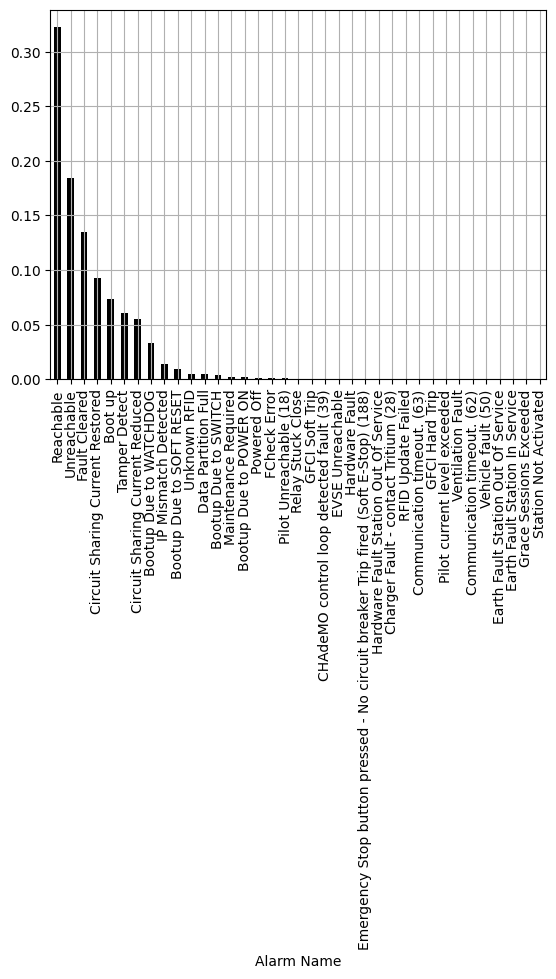

In [6]:
alarm_name_vcs = alarms['Alarm Name'].value_counts()
display(alarm_name_vcs.sort_index())
for x in alarm_name_vcs.sort_index().index:
    print(x)
# alarm_name.hist(xrot=90, bins=alarm_name.nunique(), density=True)
ax = (alarm_name_vcs / alarm_name_vcs.sum()).plot.bar(color='black')
ax.grid()


### **Uptime**

#### **State Model**

In [7]:
def calculate_state_from_alarms(alarms):
    from chargepoint import ChargerModel, AlarmEnum

    # Mapping from MAC addresses to models. Each MAC address corresponds to one unique charger model.
    models: dict[str, ChargerModel] = {}

    state_alarms = alarms.copy()
    state_alarms['State'] = pd.Series()

    # Iterate through all alarms chronologically and send to underlying charger state models. 
    for index, row in state_alarms.sort_values('Alarm Time').iterrows():
        mac = row['MAC Address']
        if mac in models:
            model = models[mac]
        else:
            model = ChargerModel(return_to_last_known_state=True)
            models[mac] = model

        alarm = AlarmEnum(row['Alarm Name'])
        model.send(alarm)
        state_alarms.loc[index, 'State'] = model.state.station_status.current_state.name

    return state_alarms

state_alarms = calculate_state_from_alarms(alarms)

In [8]:
state_alarms

,Display Name,MAC Address,Org Name,Alarm Severity,Alarm Name,Alarm ID,FRU Name,Alarm Time,Model Number,Port,Reason For Clearing,Component Serial Number,State
0,STANFORD / STATION 1 TMU,0024:B100:0003:33C3,Stanford University,,Tamper Detect,23,,2023-09-26 20:37:15-07:00,CT4020-HD-GW,,---,,Faulted
1,STANFORD / STATION 1 TMU,0024:B100:0003:33C3,Stanford University,,Tamper Detect,23,,2023-09-26 20:16:50-07:00,CT4020-HD-GW,,---,,Faulted
2,STANFORD / STATION 1 TMU,0024:B100:0003:33C3,Stanford University,,Tamper Detect,23,,2023-09-26 19:56:30-07:00,CT4020-HD-GW,,---,,Faulted
3,STANFORD / STATION 2 TMU,0024:B100:0006:BC3D,Stanford University,,Circuit Sharing Current Restored,,,2023-09-26 19:55:25-07:00,CT4020-HD-GW,1,---,,Available
4,STANFORD / CD STATION 6,0024:B100:0003:2ADF,Stanford University,,Fault Cleared,18,,2023-09-26 19:44:51-07:00,CT4020-HD,2,---,,Available
...,...,...,...,...,...,...,...,...,...,...,...,...,...
340962,ROBLE / ROBLE LL1-11,0024:B100:0002:3F5A,Stanford University,,Circuit Sharing Current Reduced,,,2018-03-30 09:39:03-07:00,CT4020-HD,1,---,,Available
340963,ROBLE / ROBLE LL1-12,0024:B100:0002:5150,Stanford University,,Circuit Sharing Current Reduced,,,2018-03-30 08:34:49-07:00,CT4020-HD-GW,2,---,,Available
340964,STANFORD / STATION 2 TMU,0024:B100:0002:1F61,Stanford University,,Circuit Sharing Current Reduced,,,2018-03-30 08:31:46-07:00,CT4020-HD,2,---,,Available
340965,STANFORD / TH STATION 1,0024:B100:0002:1F71,Stanford University,,Circuit Sharing Current Reduced,,,2018-03-30 07:40:55-07:00,CT4020-HD,1,---,,Available


#### **State History**

In [9]:
def build_state_history(state_alarms):
    # Sort state alarms by MAC Address and Alarm Time
    state_alarms = state_alarms.sort_values(['MAC Address', 'Alarm Time'])

    # For duplicate alarm times (for a given charger), only keep latest alarm
    state_alarms = state_alarms.drop_duplicates(['MAC Address', 'Alarm Time'], keep='last')

    state_history = None

    # Compute state history for each charger
    # Derived from:
    # https://www.codeforests.com/2021/03/30/group-consecutive-rows-in-pandas/
    # https://stackoverflow.com/questions/26911851/how-to-use-pandas-to-find-consecutive-same-data-in-time-series
    for mac, group in state_alarms.groupby('MAC Address'):
        group['Period'] = (group.State != group.State.shift()).cumsum()
        period_group = group.groupby('Period')
        charger_state_history = pd.DataFrame({
            'State': period_group.State.first(),
            'Time' : period_group['Alarm Time'].first(),
            'Alarms': period_group.size()}).reset_index(drop=True)

        charger_state_history['MAC Address'] = mac
        charger_state_history['Period'] = charger_state_history.index

        # Calculate duration
        charger_state_history['Duration'] = charger_state_history['Time'].shift(-1) - charger_state_history['Time']

        # Order columns
        charger_state_history = charger_state_history[['MAC Address', 'Period', 'State', 'Time', 'Duration', 'Alarms']]

        # Concat
        if state_history is None:
            state_history = charger_state_history
        else:
            state_history = pd.concat([state_history, charger_state_history])

    return state_history

state_history = build_state_history(state_alarms).dropna()

In [10]:
state_history

,MAC Address,Period,State,Time,Duration,Alarms
0,000D:6F00:04F8:B0AC,0,Available,2020-11-19 17:45:41-08:00,0 days 00:00:03,1
1,000D:6F00:04F8:B0AC,1,Faulted,2020-11-19 17:45:44-08:00,0 days 00:03:15,1
2,000D:6F00:04F8:B0AC,2,Available,2020-11-19 17:48:59-08:00,0 days 00:00:05,3
3,000D:6F00:04F8:B0AC,3,Unreachable,2020-11-19 17:49:04-08:00,0 days 00:00:01,1
4,000D:6F00:04F8:B0AC,4,Available,2020-11-19 17:49:05-08:00,0 days 00:00:04,1
...,...,...,...,...,...,...
13,0024:B100:0006:C80F,13,Unreachable,2023-08-07 22:58:26-07:00,1 days 11:31:28,1
14,0024:B100:0006:C80F,14,Available,2023-08-09 10:29:54-07:00,3 days 05:01:00,5
15,0024:B100:0006:C80F,15,Unreachable,2023-08-12 15:30:54-07:00,0 days 00:08:11,1
16,0024:B100:0006:C80F,16,Available,2023-08-12 15:39:05-07:00,14 days 15:51:10,3


#### **State Durations**

In [11]:
state_durations = state_history.pivot_table(index='MAC Address', columns='State', values='Duration', aggfunc='sum', fill_value=pd.Timedelta(seconds=0))
state_durations["Total"] = state_durations.sum(axis=1)

with pd.option_context('display.max_rows', None):
    state_durations

In [12]:
state_percentages = state_durations.divide(state_durations['Total'], axis=0) * 100

with pd.option_context('display.max_rows', None):
    state_percentages

In [13]:
print_md('##### **Ordered by Availability**')

with pd.option_context('display.max_rows', None):
    state_percentages.sort_values('Available')


##### **Ordered by Availability**

#### **Summary**

In [14]:
display(pd.concat([state_percentages.mean(), state_percentages.std()], axis=1, keys=['Mean', 'Std. Dev.']))

,Mean,Std. Dev.
State,,
Available,85.350180,16.943353
Faulted,7.942293,13.650017
Unavailable,0.876718,3.017967
Unknown,0.000005,0.000060
Unreachable,5.830804,6.767413
Total,100.000000,0.000000


#### **State History Visualized**

In [17]:
state_to_plot_map = {
    'Available': {
        'color': 'blue',
        'label': 'Available'
    },
    'Faulted': {
        'color': 'red',
        'label': 'Faulted'
    },
    'Unreachable': {
        'color': 'yellow',
        'label': 'Unreachable'
    },
    'Unavailable': {
        'color': 'gray',
        'label': 'Unavailable'
    },
    'Unknown': {
        'color': 'black',
        'label': 'Unknown'
    }
}

# %matplotlib qt
%matplotlib widget
fig, ax = plt.subplots()

for i, mac in enumerate(state_history['MAC Address'].unique()):
    # min_time = float('inf')
    y = i * 20
    for state, properties in state_to_plot_map.items():
        state_periods = state_history[(state_history['MAC Address'] == mac) & (state_history.State == state)]
        xranges = [(row.Time.timestamp(), row.Duration.total_seconds()) for _, row in state_periods.iterrows()]
        # if xranges:
        #     min_time = min(min([x[0] for x in xranges]), min_time)
        ax.broken_barh(xranges, (y, 10), **properties)
    # ax.text(min_time - 1, y, mac, ha='right', fontsize=8)
    # ax.annotate(mac, xy=(min_time, y), ha='right')

# locs = ax.get_xticks()
# labels = list(map(lambda x: pd.Timestamp(x, unit='s', tz='US/Pacific'), locs))
ax.xaxis.set_major_formatter(lambda x, pos: pd.Timestamp(x, unit='s', tz='US/Pacific'))
plt.xticks(rotation=90)
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.5, 1.1), fancybox=True, ncols=5, shadow=True)
plt.yticks([])
plt.ylabel('Charger')
plt.tight_layout()


#### **Time Averages**

In [16]:
with pd.option_context('display.max_rows', 1000):
    # x = state_history.pivot(columns='MAC Address', index='Time', values='State')
    x = state_history[state_history['MAC Address'] == '000D:6F00:04F8:B0AC'][['MAC Address', 'Time', 'State']]
    x = x.set_index('Time')
    x = x.resample('1H').nunique()
    display(x)

,MAC Address,State
Time,,
2020-11-19 17:00:00-08:00,1,3
2020-11-19 18:00:00-08:00,0,0
2020-11-19 19:00:00-08:00,0,0
2020-11-19 20:00:00-08:00,0,0
2020-11-19 21:00:00-08:00,0,0
...,...,...
2021-09-25 02:00:00-07:00,0,0
2021-09-25 03:00:00-07:00,0,0
2021-09-25 04:00:00-07:00,0,0
